# Capping / Censoring outliers

In this notebook, we will cap the variable values at certain limits.

We we calculate those limits using:

- The normal distribution
- The IQR proximity rule
- The quantiles

In a dataset like this one, we probably don't want to get rid of rare occurrences, because those would probably point us to the disease diagnosis.

Please, be mindful, when removing outliers, that they may be actually informative, depending on your use case.

In [20]:
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_palette('flare')

In [22]:
from sklearn import set_config
set_config(transform_output = 'pandas')

In [23]:
# load the California House price data from Scikit-learn
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

# let's separate the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [24]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
478,11.490,14.59,73.99,404.9,0.10460,0.08228,0.05308,0.01969,0.1779,0.06574,...,12.40,21.90,82.04,467.6,0.1352,0.2010,0.25960,0.07431,0.2941,0.09180
303,10.490,18.61,66.86,334.3,0.10680,0.06678,0.02297,0.01780,0.1482,0.06600,...,11.06,24.54,70.76,375.4,0.1413,0.1044,0.08423,0.06528,0.2213,0.07842
155,12.250,17.94,78.27,460.3,0.08654,0.06679,0.03885,0.02331,0.1970,0.06228,...,13.59,25.22,86.60,564.2,0.1217,0.1788,0.19430,0.08211,0.3113,0.08132
186,18.310,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,0.05425,...,21.31,26.36,139.20,1410.0,0.1234,0.2445,0.35380,0.15710,0.3206,0.06938
101,6.981,13.43,43.79,143.5,0.11700,0.07568,0.00000,0.00000,0.1930,0.07818,...,7.93,19.54,50.41,185.2,0.1584,0.1202,0.00000,0.00000,0.2932,0.09382


In [25]:
def Box_and_Hist_Plots(df, feature):
    """
    Функция для построения диаграммы распределения и коробки с усами
    для оценки нормальности распределения и поиска выбросов

    :param df: Исходный датафрейм
    :param feature: Имя признака для анализа
    :return: Выводит график
    """

    fig, ax = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)})

    sns.boxplot(x=df[feature], ax=ax[0])
    sns.histplot(data=df, x=feature, ax=ax[1])

    ax[0].set(xlabel="")
    ax[0].set_title(f"Box-Plot and Distribution for {feature}")
    plt.tight_layout()
    plt.show()

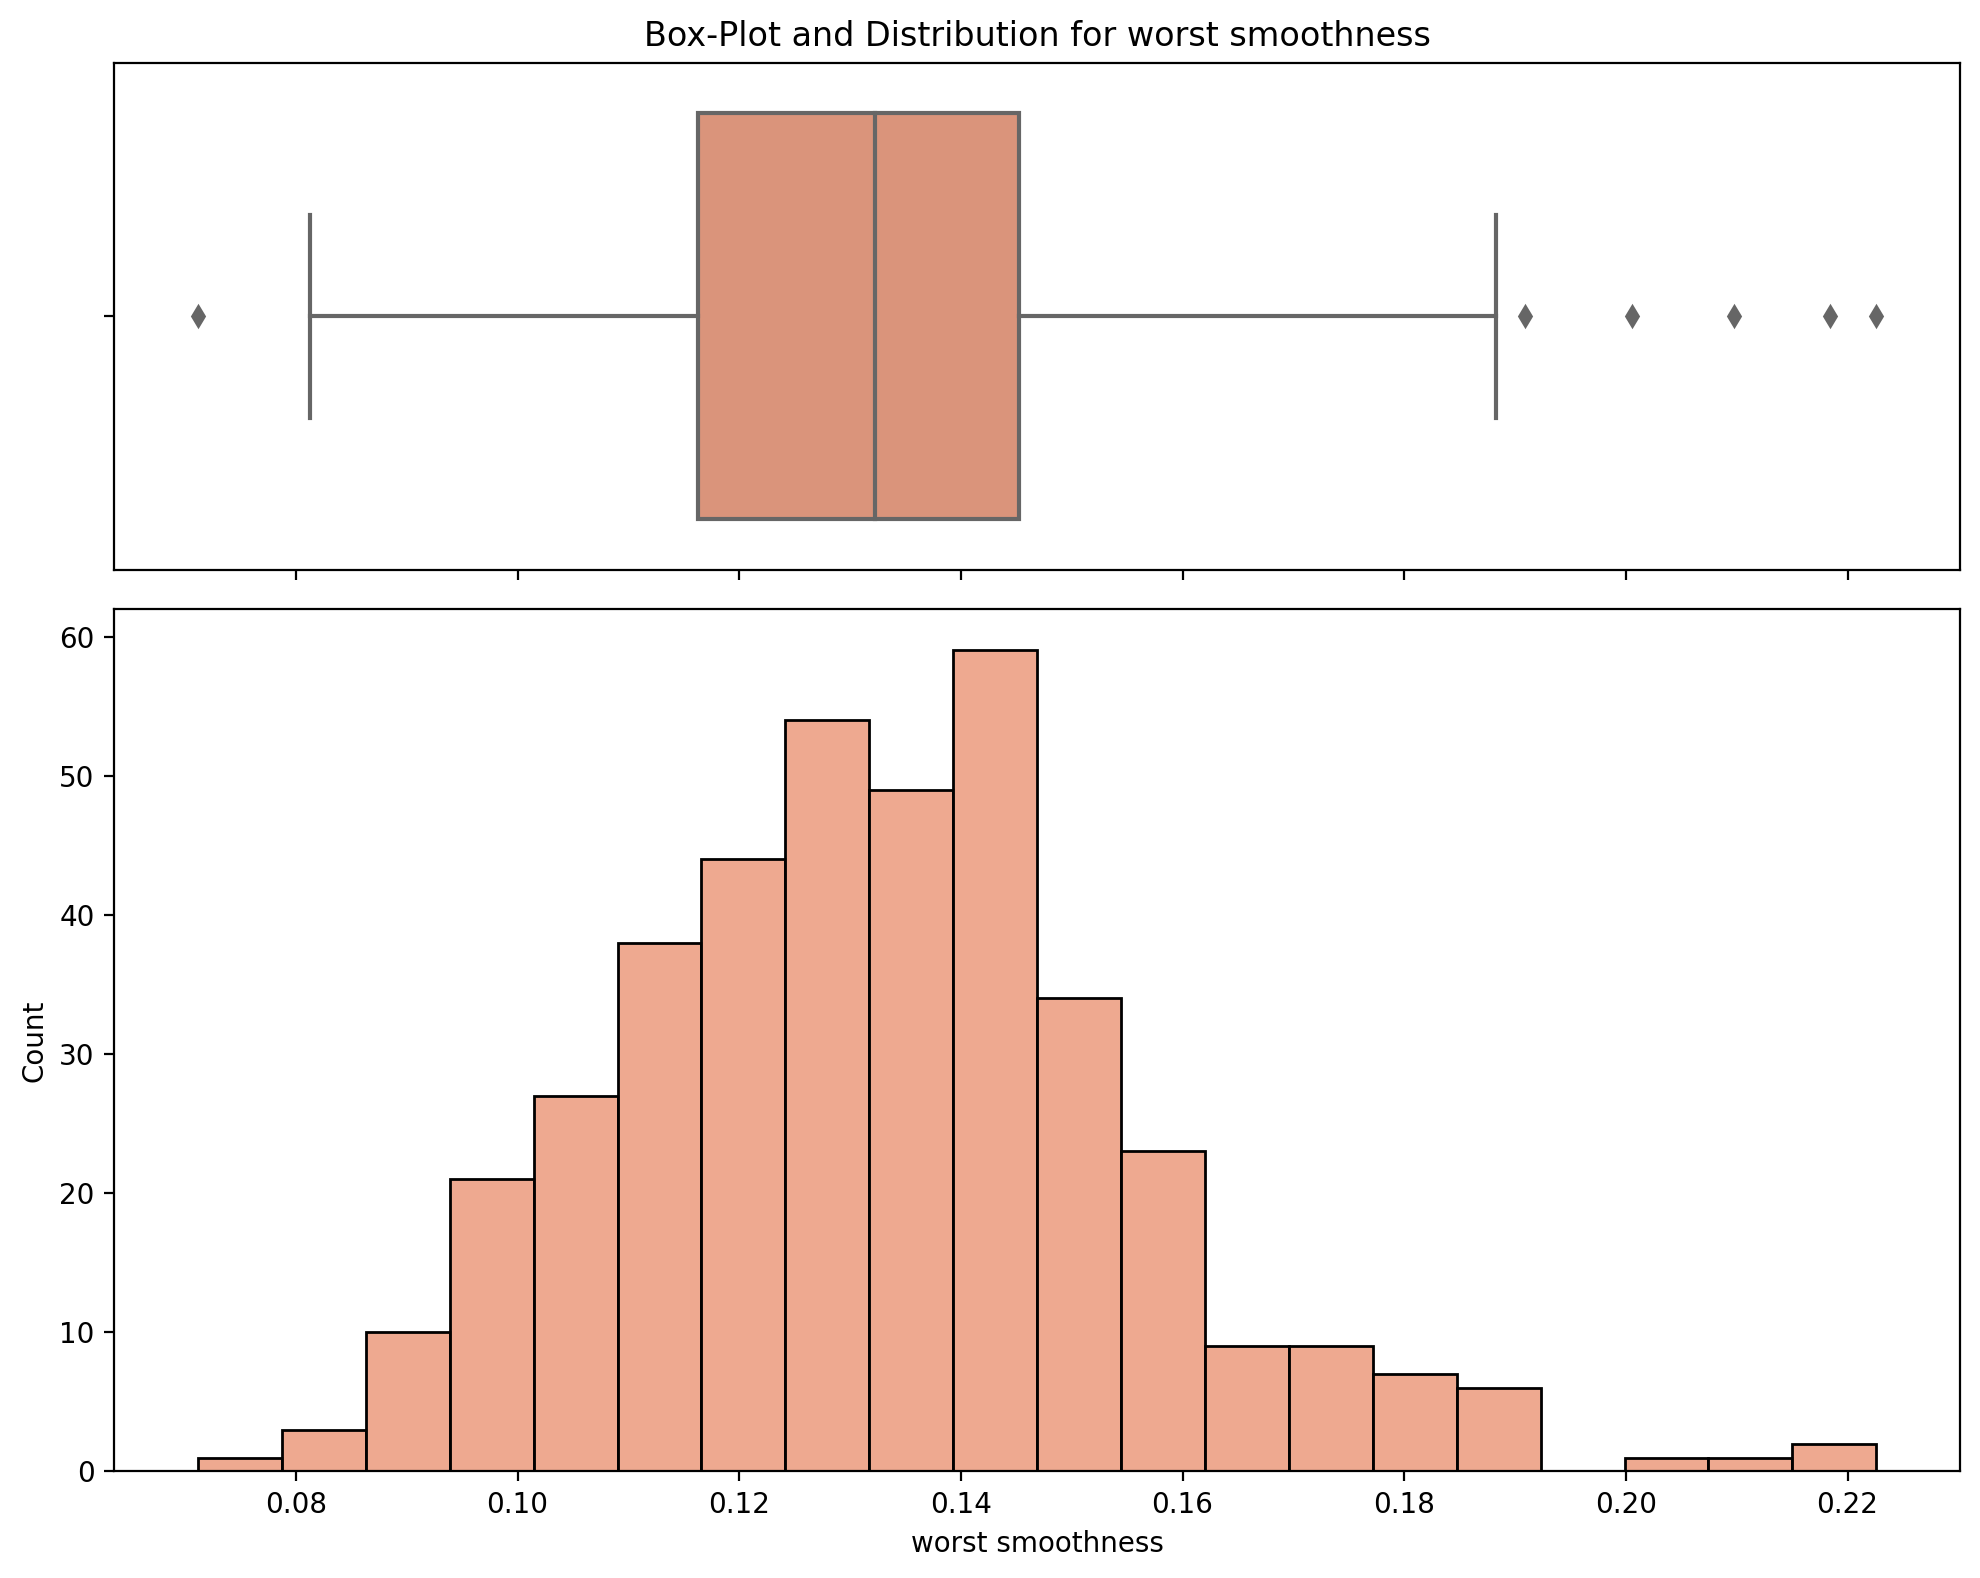

In [26]:
Box_and_Hist_Plots(X_train, "worst smoothness")

## Normal distribution

In [27]:
def find_limits(df, feature, fold):
    x = df[feature]
    
    mu = x.mean()
    sigma = x.std()

    lower_limit = mu - sigma * fold
    upper_limit = mu + sigma * fold

    return lower_limit, upper_limit

In [28]:
# we find the limits
lower_limit, upper_limit = find_limits(X_train, "worst smoothness", 3)
lower_limit, upper_limit

(0.06356074164705164, 0.20149734880520967)

In [29]:
# limits before capping:
X_train["worst smoothness"].min(), X_train["worst smoothness"].max()

(0.07117, 0.2226)

In [30]:
# Cap variables
X_train["worst smoothness"].clip(lower=lower_limit, upper=upper_limit, inplace=True)
X_test["worst smoothness"].clip(lower=lower_limit, upper=upper_limit, inplace=True)

In [31]:
# limits after capping:
X_train["worst smoothness"].min(), X_train["worst smoothness"].max()

(0.07117, 0.20149734880520967)

In [32]:
# the size remains the same, we are capping,
# not removing values in this case
X_train.shape, X_test.shape

((398, 30), (171, 30))

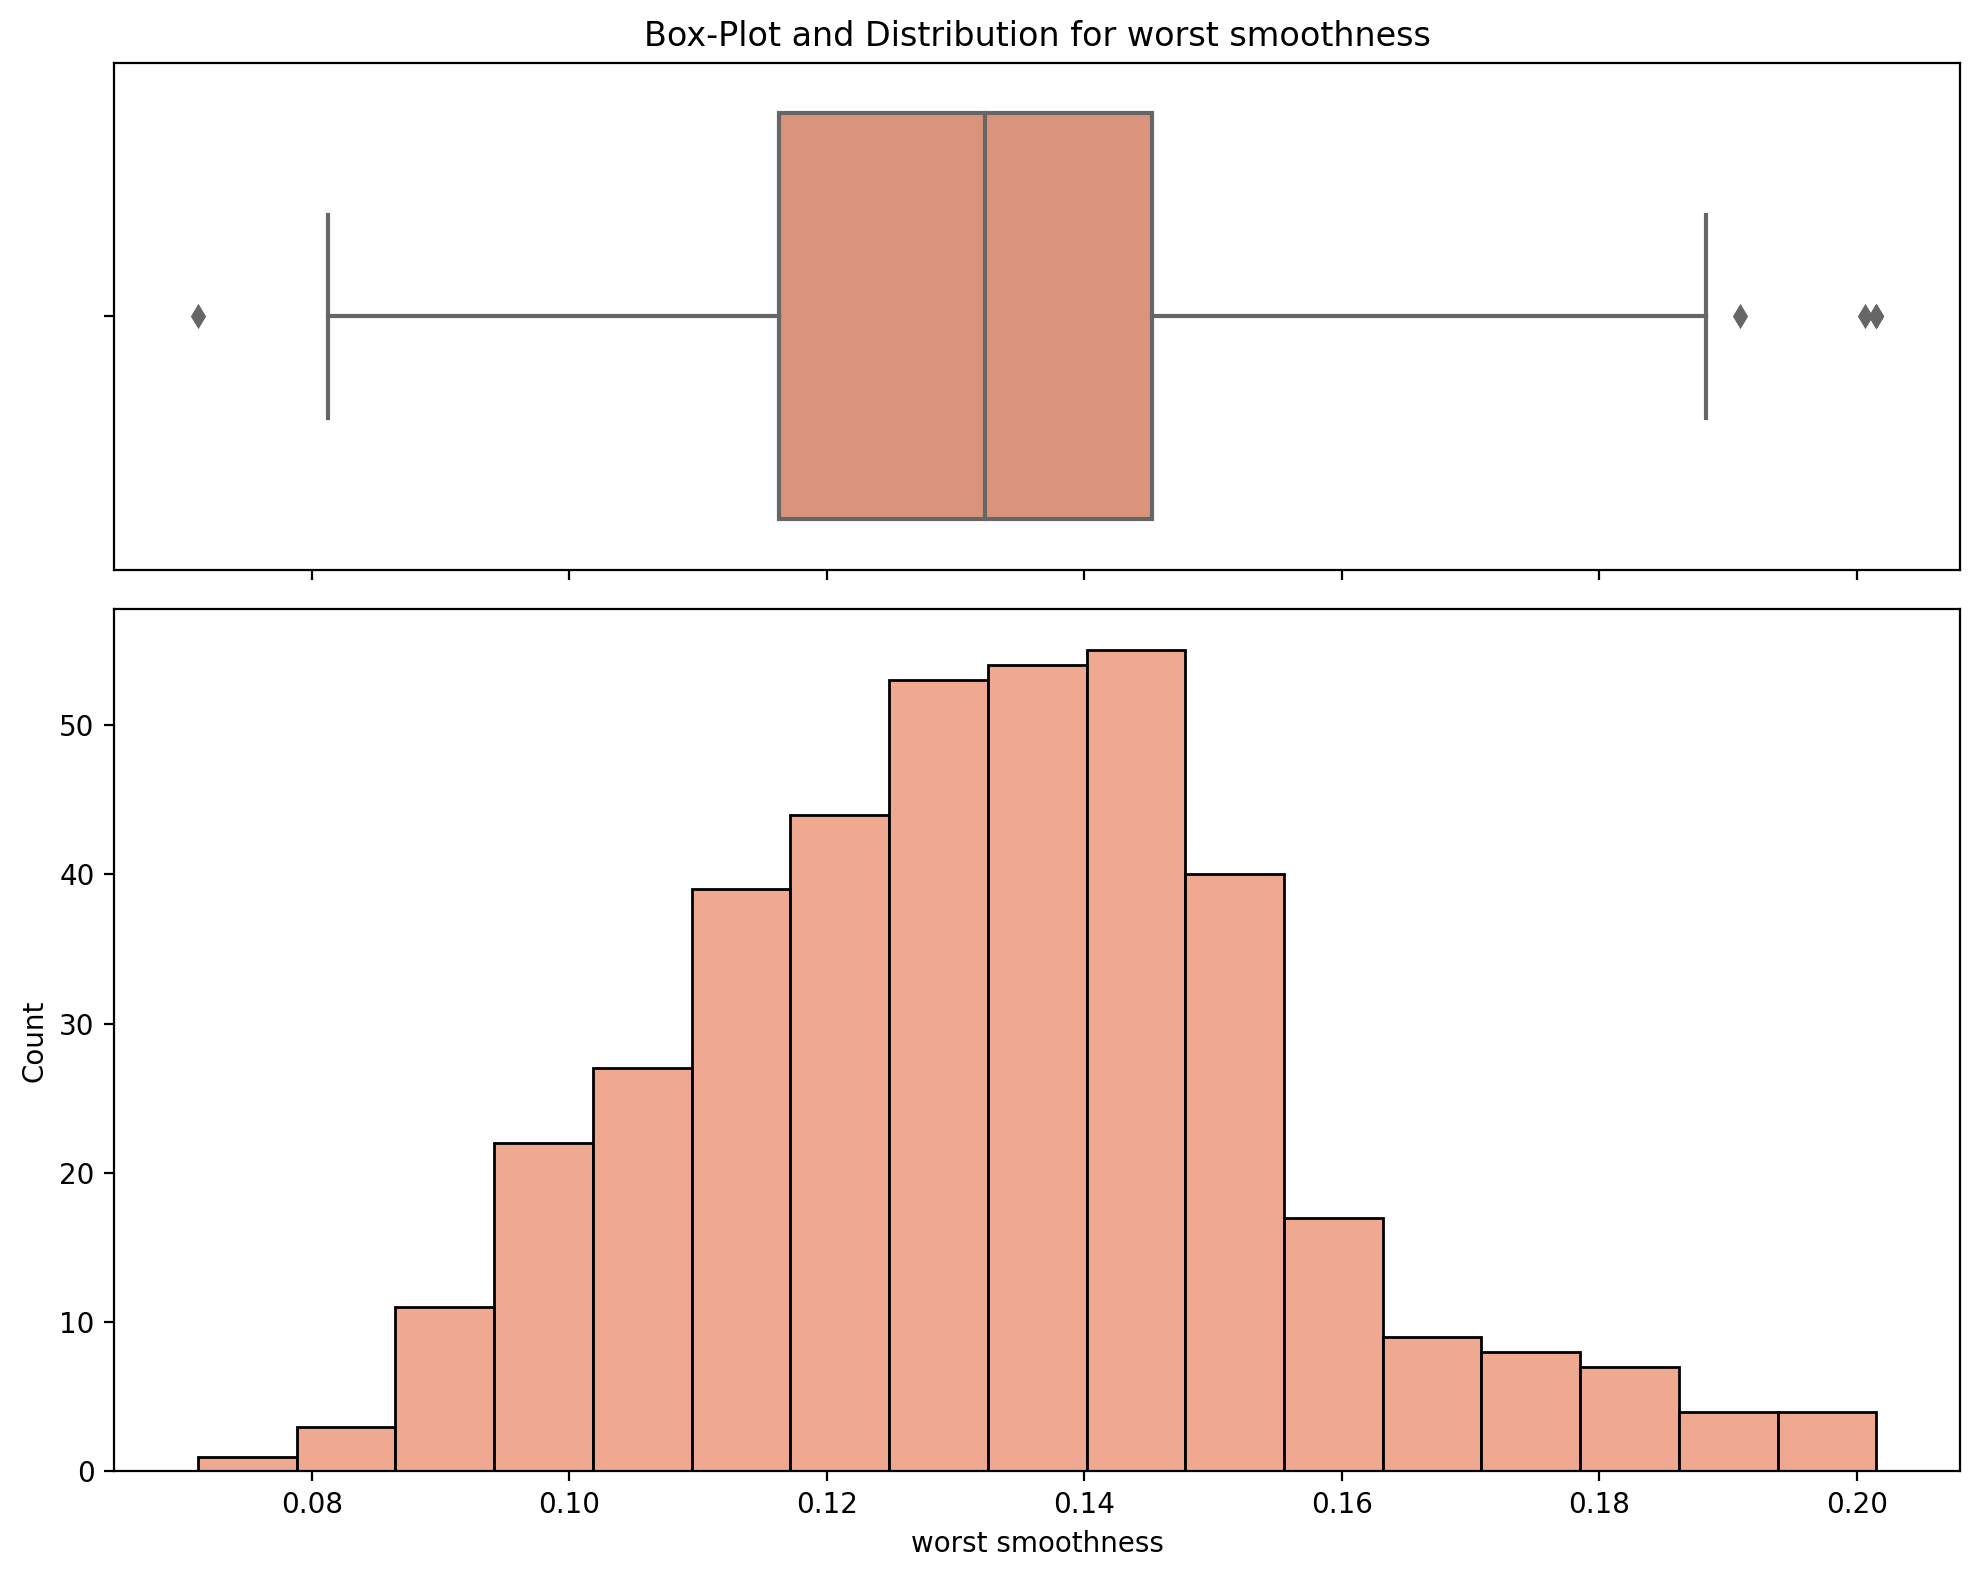

In [33]:
Box_and_Hist_Plots(X_train, "worst smoothness")

# Sklearn implementation

In [34]:
# load the California House price data from Scikit-learn
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

# let's separate the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

In [36]:
class CappingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature, fold=1.5, find_limits_func=None):
        self.feature = feature
        self.fold = fold
        self.lower_limit = None
        self.upper_limit = None
        self.find_limits_func = find_limits_func

    def fit(self, X, y=None):
        if self.find_limits_func:
            self.lower_limit, self.upper_limit = self.find_limits_func(X, self.feature, self.fold)
        return self

    def transform(self, X, y=None):
        X[self.feature].clip(lower=self.lower_limit, upper=self.upper_limit, inplace=True)
        return X

In [37]:
# Example usage
from sklearn.pipeline import Pipeline

ct = CappingTransformer(feature='worst smoothness', fold=3, find_limits_func=find_limits)

pipeline = Pipeline([
    ('ct', ct)
])

# Fit the pipeline on the training data
pipeline.fit(X_train)

# Transform both training and test data
X_train_ct = pipeline.transform(X_train)
X_test_ct = pipeline.transform(X_test)

In [38]:
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
478,11.490,14.59,73.99,404.9,0.10460,0.08228,0.05308,0.01969,0.1779,0.06574,...,12.400,21.90,82.04,467.6,0.13520,0.20100,0.25960,0.07431,0.2941,0.09180
303,10.490,18.61,66.86,334.3,0.10680,0.06678,0.02297,0.01780,0.1482,0.06600,...,11.060,24.54,70.76,375.4,0.14130,0.10440,0.08423,0.06528,0.2213,0.07842
155,12.250,17.94,78.27,460.3,0.08654,0.06679,0.03885,0.02331,0.1970,0.06228,...,13.590,25.22,86.60,564.2,0.12170,0.17880,0.19430,0.08211,0.3113,0.08132
186,18.310,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,0.05425,...,21.310,26.36,139.20,1410.0,0.12340,0.24450,0.35380,0.15710,0.3206,0.06938
101,6.981,13.43,43.79,143.5,0.11700,0.07568,0.00000,0.00000,0.1930,0.07818,...,7.930,19.54,50.41,185.2,0.15840,0.12020,0.00000,0.00000,0.2932,0.09382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,18.810,19.98,120.90,1102.0,0.08923,0.05884,0.08020,0.05843,0.1550,0.04996,...,19.960,24.30,129.00,1236.0,0.12430,0.11600,0.22100,0.12940,0.2567,0.05737
9,12.460,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,15.090,40.68,97.65,711.4,0.18530,1.05800,1.10500,0.22100,0.4366,0.20750
359,9.436,18.32,59.82,278.6,0.10090,0.05956,0.02710,0.01406,0.1506,0.06959,...,12.020,25.02,75.79,439.6,0.13330,0.10490,0.11440,0.05052,0.2454,0.08136
192,9.720,18.22,60.73,288.1,0.06950,0.02344,0.00000,0.00000,0.1653,0.06447,...,9.968,20.83,62.25,303.8,0.07117,0.02729,0.00000,0.00000,0.1909,0.06559


In [39]:
X_train["worst smoothness"].min(), X_train["worst smoothness"].max()

(0.07117, 0.20149734880520967)

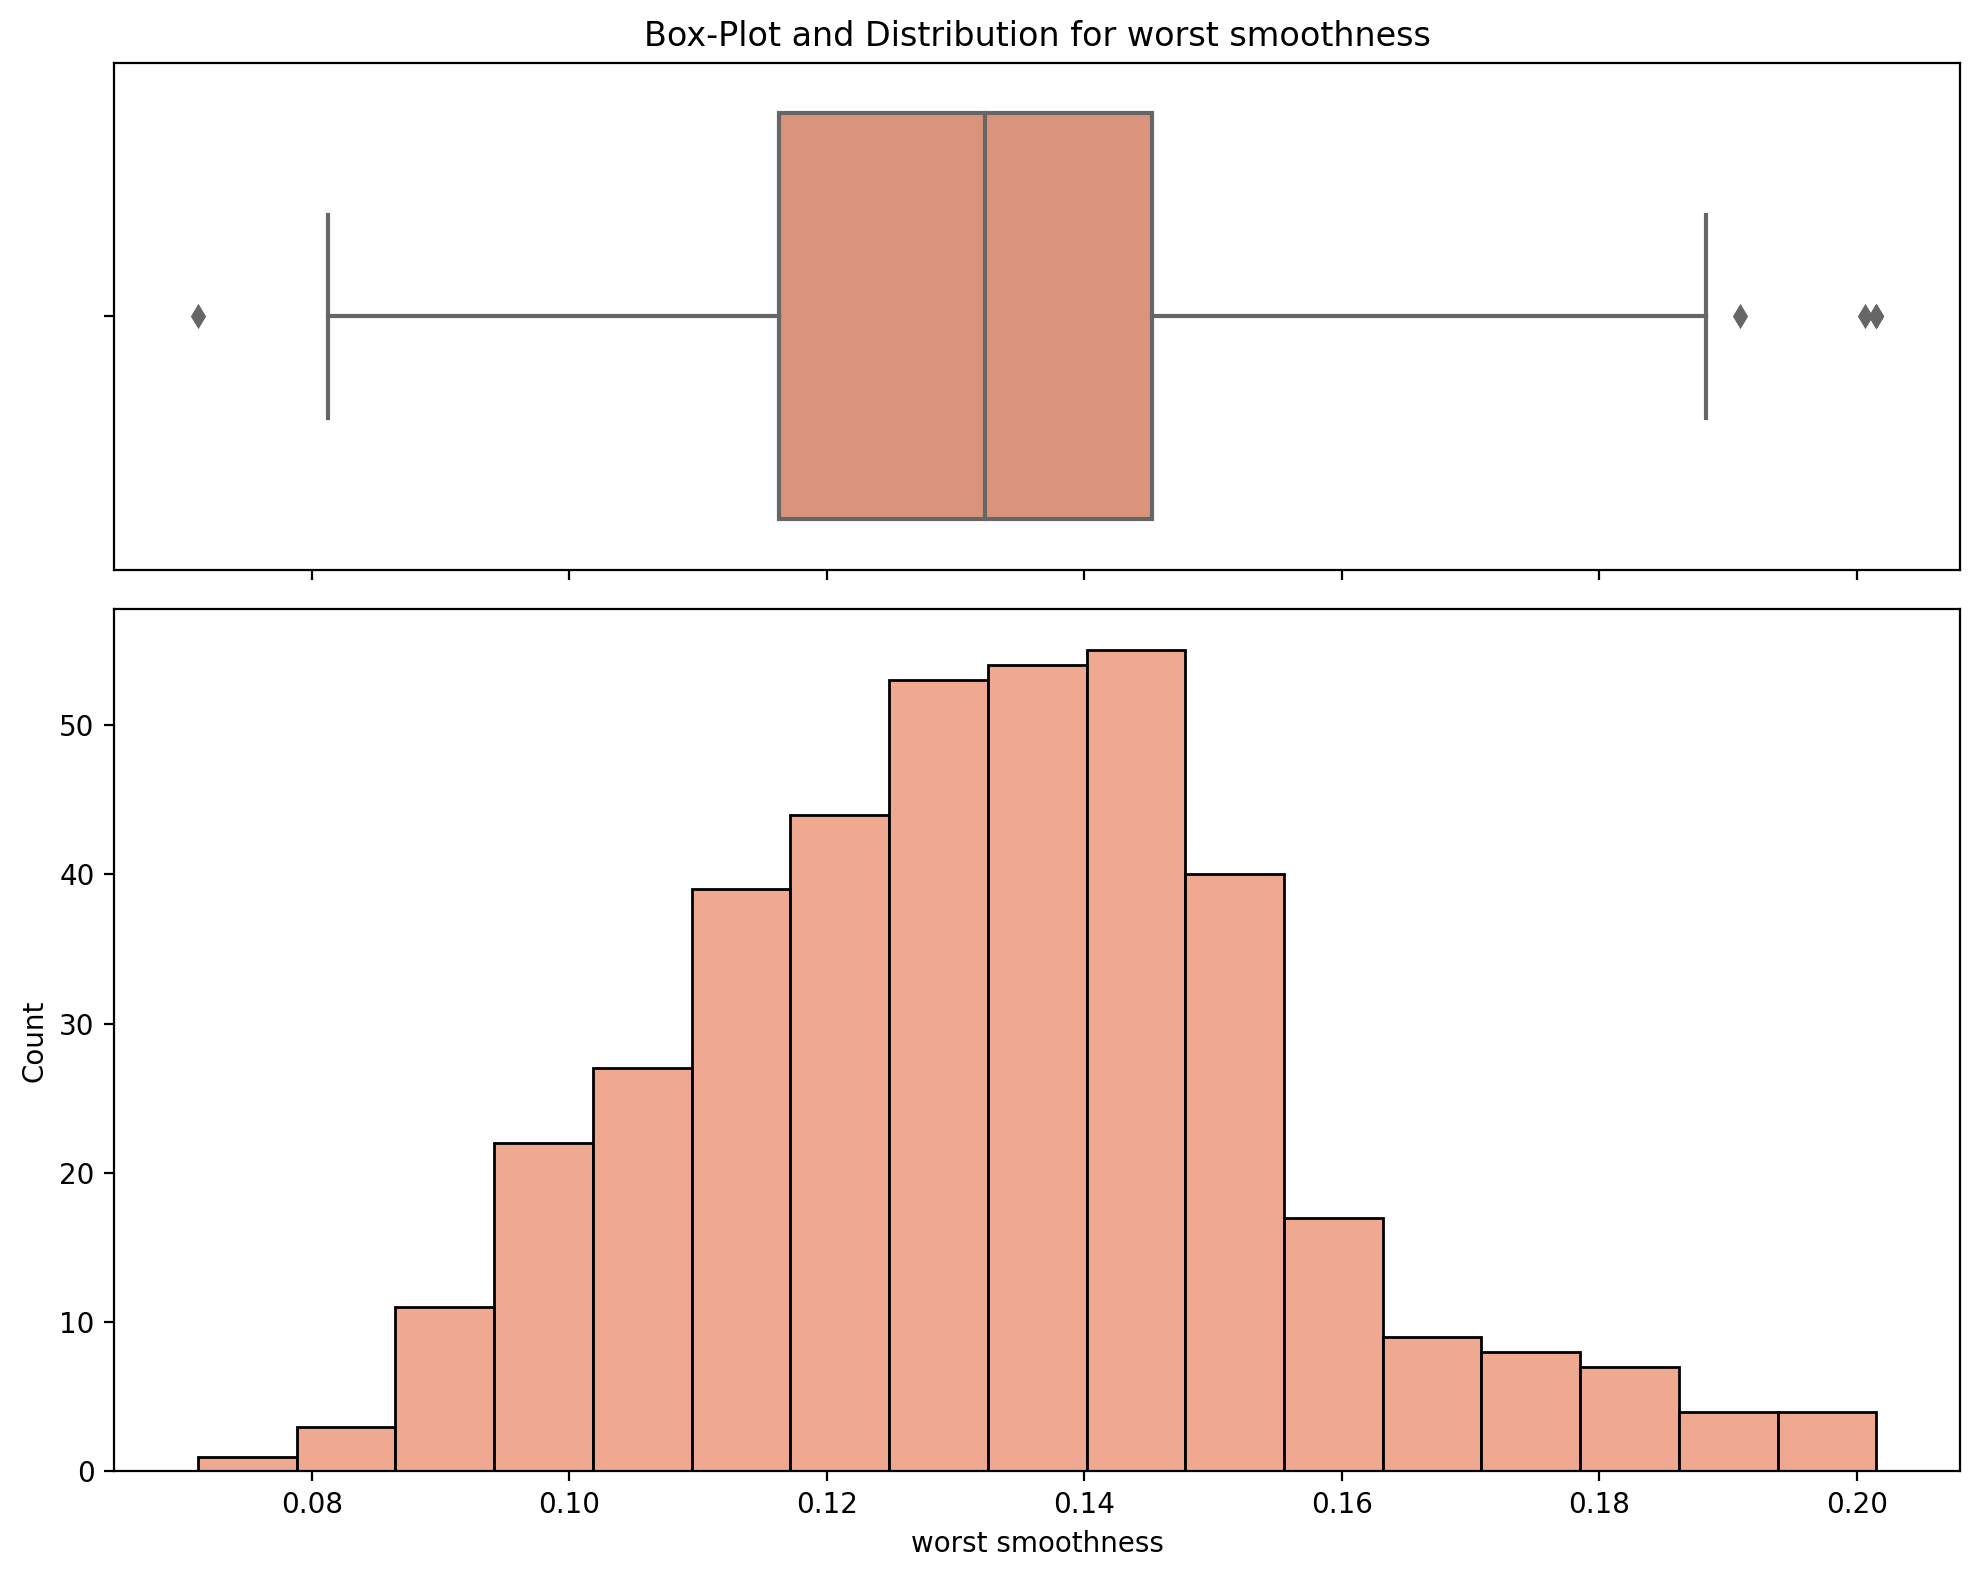

In [40]:
Box_and_Hist_Plots(X_train_ct, "worst smoothness")